In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [2]:
#load out dataset
features = np.load('../logs_train/ResNet18/features.npy')


In [3]:
from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(features)
scaled_features.shape


(2368, 512)

In [4]:
import umap

reducer = umap.UMAP()

embeddings = reducer.fit_transform(scaled_features)


/opt/conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_379199/944491898.py:24: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


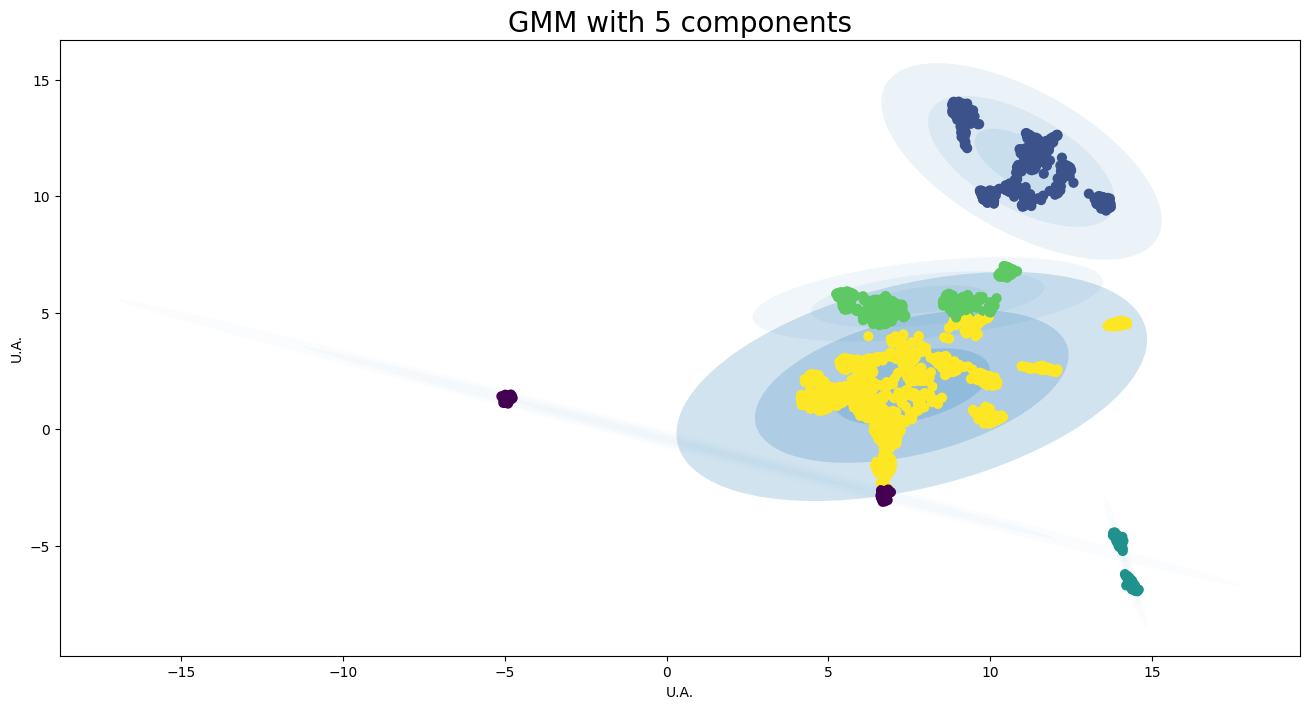

In [5]:
gmm=GMM(5).fit(features) 
plot_gmm(gmm, embeddings)

/tmp/ipykernel_379199/944491898.py:24: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


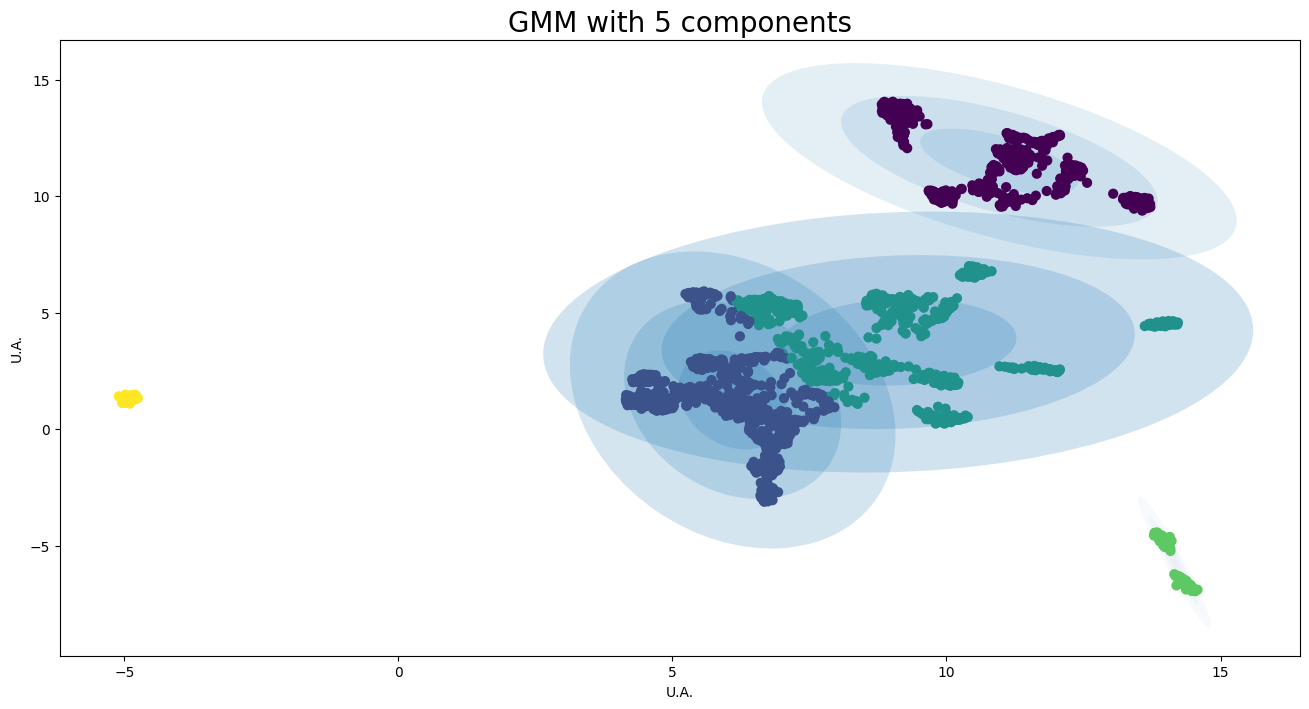

In [6]:
#note: since we did not set a random seed, different runs will have (in general) different results!
#This cell has the same parameters of the one before, but the results show different clusters 
gmm=GMM(5).fit(features) 
plot_gmm(gmm, embeddings)

## Silohuette coefficient

In [7]:
n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(features) 
        labels=gmm.predict(features)
        sil=metrics.silhouette_score(features, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

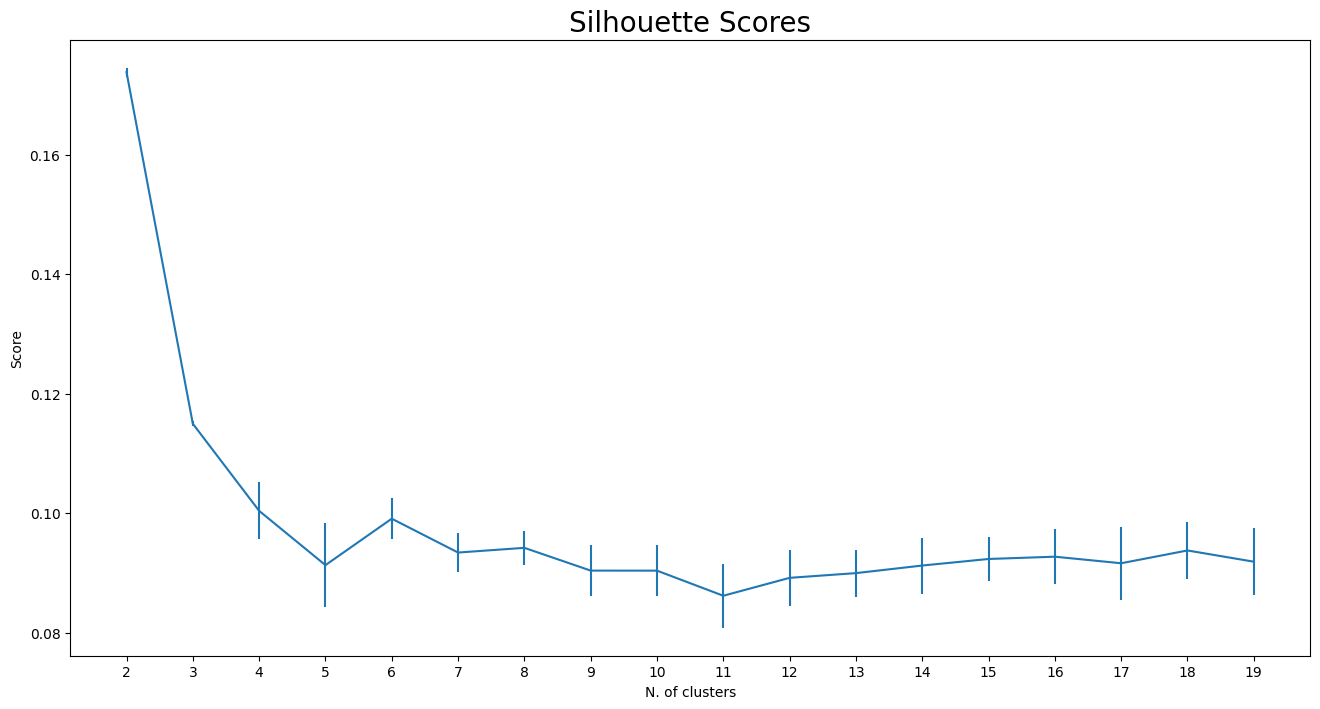

In [8]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [ ]:
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=15
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(scaled_features) 
        labels=gmm.predict(scaled_features)
        sil=metrics.silhouette_score(scaled_features, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

## Train - Test distance check

In [37]:
#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [99]:
n_clusters=np.arange(2, 20)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(embeddings, test_size=0.5)
        
        gmm_train=GMM(n, n_init=2).fit(train) 
        gmm_test=GMM(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)
    

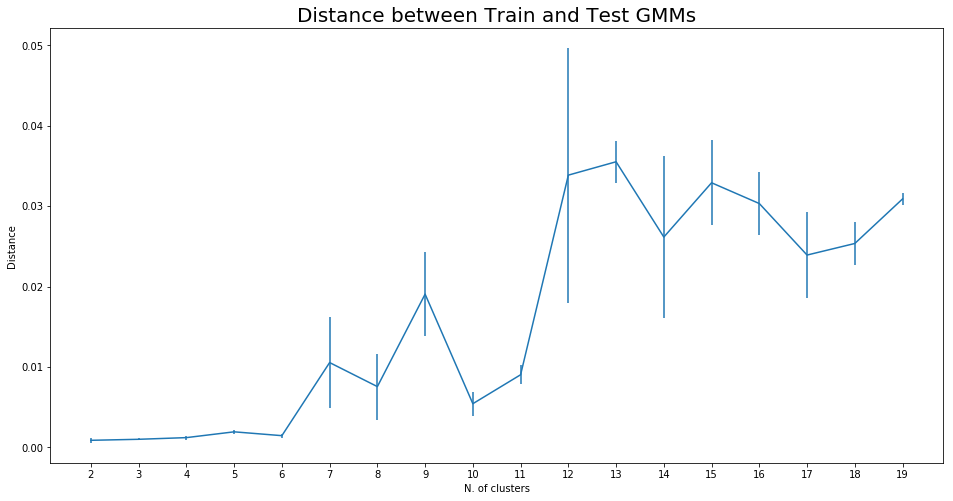

In [101]:
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

### BIC

In [103]:
n_clusters=np.arange(2, 20)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(embeddings) 
        
        tmp_bic.append(gmm.bic(embeddings))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

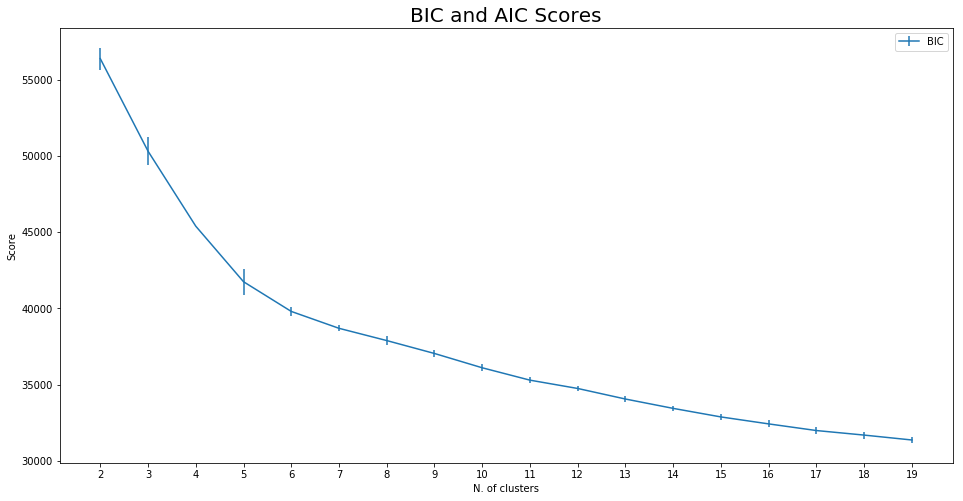

In [109]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

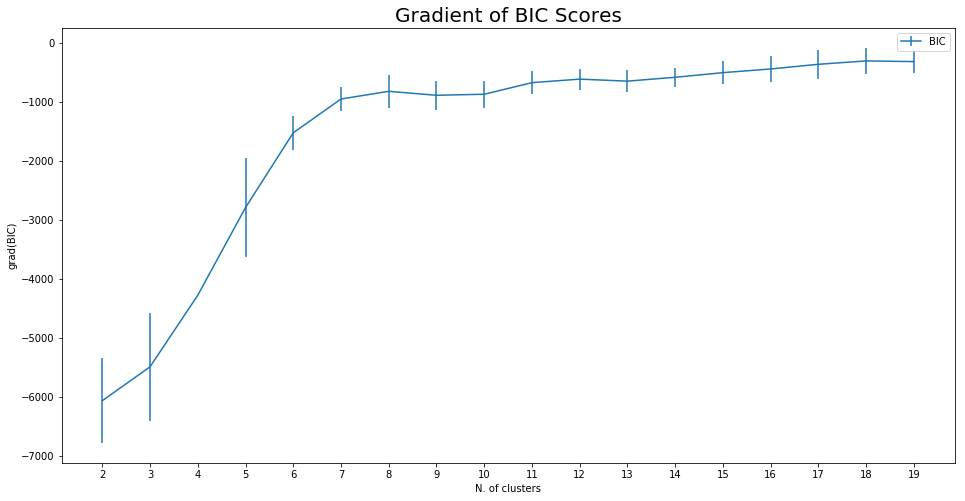

In [117]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [129]:
import pandas as pd
obj={'Metric': ['Silohuette score', 'Distance between Train and Test GMMs', 'Gradient of BIC scores'],
    "number of clusters": [5,6,6]}
df=pd.DataFrame(obj)
df.set_index('Metric')

,number of clusters
Metric,
Silohuette score,5
Distance between Train and Test GMMs,6
Gradient of BIC scores,6
